# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [2]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library2D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device="cpu"
print(device)

cpu


## Prepare the data

Next, we prepare the dataset.

In [3]:
def create_data():
    data = loadmat('data/advection_diffusion.mat')
    usol = np.real(data['Expression1']).astype("float32")
    usol= torch.from_numpy(usol.reshape((51,51,61,4))).float()
    print(usol.shape)
    coords = usol[:,:,:,0:3].reshape(-1, 3)
    print(coords.shape)
    data = usol[:,:,:,3].reshape(-1,1)
    print(data.shape)
    return coords, data

In [4]:
dataset = Dataset(create_data, preprocess_kwargs={"noise_level":0.1},subsampler=Subsample_random, subsampler_kwargs={"number_of_samples":200}, normalize_coords=True, normalize_data=True, device=device)

torch.Size([51, 51, 61, 4])
torch.Size([158661, 3])
torch.Size([158661, 1])
device:  cpu


Next we plot the dataset for three different time-points

NameError: name 'x_v' is not defined

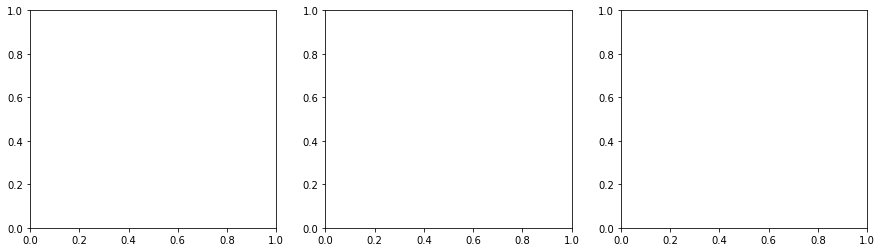

In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_v[:,:,0], y_v[:,:,0], u_v[:,:,0], cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t = 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

We flatten it to give it the right dimensions for feeding it to the network:

In [12]:
X = np.transpose((t_v.flatten(),x_v.flatten(), y_v.flatten()))
y = np.float32(u_v.reshape((u_v.size, 1)))

NameError: name 't_v' is not defined

We select the noise level we add to the data-set

In [13]:
noise_level = 0.01

In [14]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

NameError: name 'y' is not defined

Select the number of samples:

In [15]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

NameError: name 'y' is not defined

In [6]:
train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.5
)

1


In [7]:
print(len(train_dataloader))

1


In [8]:
for train in train_dataloader:
    print(train)

(tensor([], size=(0, 3)), tensor([], size=(0, 1)))


## Configuration of DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [9]:
network = NN(3, [50, 50, 50,50], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_y, u_{xx}, u_{yy}, u_{xy}, u, u u_x, u u_y, u u_{xx}, u u_{yy}, u u_{xy}$]

In [10]:
library = Library2D(poly_order=1) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [11]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [12]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [13]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [14]:
train(model, train_dataloader, test_dataloader, optimizer,sparsity_scheduler, log_dir='runs/2DAD/', split=0.8, max_iterations=100000, delta=1e-4, patience=8) 

TypeError: 'tuple' object is not callable

Sparsity masks provide the active and non-active terms in the PDE:

In [15]:
model.sparsity_masks

estimatior_coeffs gives the magnitude of the active terms:

In [16]:
print(model.estimator_coeffs())

None
